In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [8]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 22  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM =1024
    IMAGE_MAX_DIM =1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH =50

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                35
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INST

In [9]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [10]:
class DrugDataset(utils.Dataset):

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_json_get_labels_form(self,image_id):
        info = self.image_info[image_id]
        with open(info['json_path']) as f:
            data = json.load(f)
        data_info = data['objects']
        count_list = []
        labels_form = []
        for i in range(len(data_info)):
            count_list.append(data_info[i]['label'])
        for i in count_list:
            if i == 17:
                labels_form.append('sky')
            elif i == 33 or i == 161:
                labels_form.append(('car'))
            elif i == 34 or i == 162:
                labels_form.append('motorbicycle')
            elif i == 35 or i == 163:
                labels_form.append(('bicycle'))
            elif i == 38:
                labels_form.append('truck')
            elif i == 40:
                labels_form.append(('tricycle'))
            elif i == 36 or i == 164:
                labels_form.append('person')
            elif i == 37 or i == 165:
                labels_form.append(('rider'))
            elif i == 38 or i == 166:
                labels_form.append('truck')
            elif i == 39 or i == 167:
                labels_form.append(('bus'))
            elif i == 40 or i == 168:
                labels_form.append('tricycle')
            elif i == 49:
                labels_form.append(('road'))
            elif i == 50:
                labels_form.append('siderwalk')
            elif i == 65:
                labels_form.append(('traffic_cone'))
            elif i == 66:
                labels_form.append('road_pile')
            elif i == 67:
                labels_form.append(('fence'))
            elif i == 81:
                labels_form.append('traffic_light')
            elif i == 82:
                labels_form.append(('pole'))
            elif i == 83:
                labels_form.append('traffic_sign')
            elif i == 84:
                labels_form.append(('wall'))
            elif i == 85:
                labels_form.append('dustbin')
            elif i == 86:
                labels_form.append(('billboard'))
            elif i == 97:
                labels_form.append('building')
            elif i == 113:
                labels_form.append('vegatation')
        labels_form_re=[]
        for i in labels_form:
            if i not in labels_form_re:
                labels_form_re.append(i)
        num_obj=len(labels_form_re)
        return labels_form_re,num_obj
    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        #print("info-->",info)
        #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel==255:
                        mask[j, i, index] = 0
                    else:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, width,height,img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "sky")
        self.add_class("shapes", 2, "car")
        self.add_class("shapes", 3, "motorbicycle")
        self.add_class("shapes", 4, "bicycle")
        self.add_class("shapes", 5, "person")
        self.add_class("shapes", 6, "rider")
        self.add_class("shapes", 7, "truck")
        self.add_class("shapes", 8, "bus")
        self.add_class("shapes", 9, "tricycle")
        self.add_class("shapes", 10, "road")
        self.add_class("shapes", 11, "siderwalk")
        self.add_class("shapes", 12, "traffic_cone")
        self.add_class("shapes", 13, "road_pile")
        self.add_class("shapes", 14, "fence")
        self.add_class("shapes", 15, "traffic_light")
        self.add_class("shapes", 16, "pole")
        self.add_class("shapes", 17, "traffic_sign")
        self.add_class("shapes", 18, "wall")
        self.add_class("shapes", 19, "dustbin")
        self.add_class("shapes", 20, "billboard")
        self.add_class("shapes", 21, "building")
        self.add_class("shapes", 22, "vegatation")

        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            mask_path = mask_floder + "/" + filestr + "_instanceIds.png"
            json_path = "/home/mt/桌面/Mask_RCNN-master/train_data/cv2_mask" + "/" + filestr + ".json"

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                            width=width, height=height, mask_path=mask_path,json_path=json_path)
            #
            # self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
            #                width=width, height=height, mask_path=mask_path,json_path=json_path)

    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        info = self.image_info[image_id]
        # count = 1  # number of object
        img = Image.open(info['mask_path'])
        labels_form_re,num_obj = self.from_json_get_labels_form(image_id)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        # occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        # for i in range(num_obj- 2, -1, -1):
        #     mask[:, :, i] = mask[:, :, i] * occlusion
        #     occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = np.array([self.class_names.index(s) for s in labels_form_re])
        return mask, class_ids.astype(np.int32)

In [11]:
dataset_root_path="/home/mt/桌面/Mask_RCNN-master/train_data"
img_floder = dataset_root_path + "/re_pic"
mask_floder = dataset_root_path + "/re_cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count,1024,1024,img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()

#print("dataset_train-->",dataset_train._image_ids)

dataset_val = DrugDataset()
dataset_val.load_shapes(7,1024,1024,img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 10


In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/mt/桌面/Mask_RCNN-master/logs/shapes20180920T1942/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/home/mt/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/mt/.local/lib/python3.5/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 12/100 [==>...........................] - ETA: 29:02 - loss: 3.6557 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.3642 - mrcnn_class_loss: 1.1940 - mrcnn_bbox_loss: 0.6694 - mrcnn_mask_loss: 0.3808

ERROR:root:Error processing image {'path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/pic/170908_073056033_Camera_5.jpg', 'source': 'shapes', 'height': 2710, 'width': 3384, 'id': 117, 'json_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073056033_Camera_5.json', 'mask_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073056033_Camera_5_instanceIds.png'}
Traceback (most recent call last):
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1226, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/utils.py", line 457, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/

 15/100 [===>..........................] - ETA: 29:05 - loss: 3.3773 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2977 - mrcnn_class_loss: 0.9937 - mrcnn_bbox_loss: 0.7035 - mrcnn_mask_loss: 0.3407

ERROR:root:Error processing image {'path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/pic/170908_073054993_Camera_6.jpg', 'source': 'shapes', 'height': 2710, 'width': 3384, 'id': 303, 'json_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073054993_Camera_6.json', 'mask_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073054993_Camera_6_instanceIds.png'}
Traceback (most recent call last):
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1226, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/utils.py", line 457, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/

 19/100 [====>.........................] - ETA: 28:56 - loss: 3.2646 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.2311 - mrcnn_class_loss: 0.8626 - mrcnn_bbox_loss: 0.7787 - mrcnn_mask_loss: 0.3558

Traceback (most recent call last):
  File "/home/mt/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/usr/lib/python3.5/multiprocessing/managers.py", line 716, in _callmethod
    conn.send((self._id, methodname, args, kwds))
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 206, in send
    self._send_bytes(ForkingPickler.dumps(obj))
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Process Process-2:
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run(

 22/100 [=====>........................] - ETA: 25:23 - loss: 3.0000 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.1808 - mrcnn_class_loss: 0.7505 - mrcnn_bbox_loss: 0.7134 - mrcnn_mask_loss: 0.3212

Traceback (most recent call last):
  File "/home/mt/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "<string>", line 2, in put
  File "/usr/lib/python3.5/multiprocessing/managers.py", line 716, in _callmethod
    conn.send((self._id, methodname, args, kwds))
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 206, in send
    self._send_bytes(ForkingPickler.dumps(obj))
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Process Process-3:
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run(

 99/100 [============================>.] - ETA: 11s - loss: 2.0537 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.8686 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.6371 - mrcnn_mask_loss: 0.2795

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers="all")


Starting at epoch 4. LR=0.0001

Checkpoint Path: /home/mt/桌面/Mask_RCNN-master/logs/shapes20180921T1004/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

/home/mt/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/mt/.local/lib/python3.5/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/30


ERROR:root:Error processing image {'mask_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073031701_Camera_6_instanceIds.png', 'source': 'shapes', 'json_path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/cv2_mask/170908_073031701_Camera_6.json', 'width': 3384, 'height': 2710, 'path': '/media/mt/Seagate Backup Plus Drive/road01_ins/train_data/pic/170908_073031701_Camera_6.jpg', 'id': 3}
Traceback (most recent call last):
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/model.py", line 1226, in load_image_gt
    mode=config.IMAGE_RESIZE_MODE)
  File "/home/mt/桌面/Mask_RCNN-master/mrcnn/utils.py", line 457, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/usr/local/lib/py

ResourceExhaustedError: OOM when allocating tensor with shape[1,256,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/AddN_44-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/gradients/roi_align_classifier_2/CropAndResize_grad/CropAndResizeGradImage, mrcnn_mask_loss_2/transpose/perm)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [16]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/mt/桌面/Mask_RCNN-master/re_logs/shapes20180924T1235/mask_rcnn_shapes_0010.h5
Re-starting from epoch 10


In [17]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (35,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (4,)                  min:    2.00000  max:    7.00000  int32
gt_bbox                  shape: (4, 4)                min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  uint8


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 35)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.53085  max:    1.46829  float32


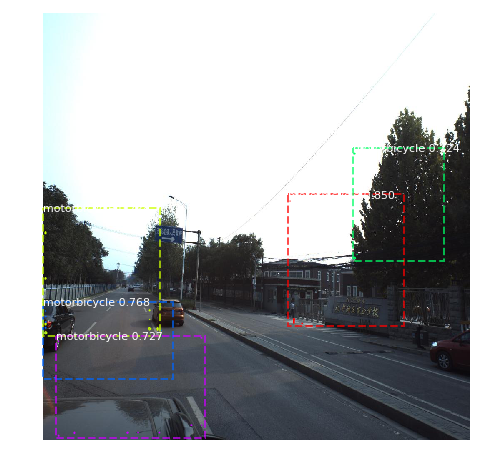

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())